# Imports

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shap
shap.initjs()

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

## Metrics
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (auc,roc_auc_score, ConfusionMatrixDisplay, 
                             precision_score, PrecisionRecallDisplay,
                             recall_score, roc_curve,RocCurveDisplay, f1_score,
                             accuracy_score, classification_report)

# Functions

In [2]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
  ## Get the classification report
  report = classification_report(y_true, y_pred)
    
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
    
  ## Confusion matrices subplots
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
  ## Confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0]);
  axes[0].set_title("Raw Counts")
  
  ## Confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")

  ## Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  
  ## Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [3]:
def multiclass_roc_auc_score(model, X_test, y_test, num_classes):
    # Binarize the output labels
    y_binarized = label_binarize(y_test, classes=[*range(num_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_prob = model.predict_proba(X_test)
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plotting each class's ROC curve (optional)
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {i}')
        plt.legend(loc="lower right")
        plt.show()

    # Calculate the average ROC AUC score
    average_roc_auc = np.mean(list(roc_auc.values()))
    print(f"Average ROC AUC score: {average_roc_auc}")

    return roc_auc, average_roc_auc

In [4]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, num_classes=3,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    ## Get predictions & probability for training data
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)
    
    ## Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    ## Get predictions & probability for test data
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    
    ## Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data')
    
    ## Visualize the ROC curve
    multiclass_roc_auc_score(model, X_test, y_test, num_classes)
    
    
    if output_dict == True:
        ## Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

# Load Data

In [5]:
## Load unprocessed data to avoid data leakage
df = pd.read_csv('Data/fall_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Distance       2039 non-null   float64
 1   Pressure       2039 non-null   float64
 2   HRV            2039 non-null   float64
 3   Sugar level    2039 non-null   float64
 4   SpO2           2039 non-null   float64
 5   Accelerometer  2039 non-null   float64
 6   Decision       2039 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 111.6 KB


Distance  Pressure      HRV  Sugar level    SpO2  Accelerometer  Decision 
0    25.540       1.0  101.396       61.080  87.770            1.0          1
1     2.595       2.0  110.190       20.207  65.190            1.0          2
2    68.067       0.0   87.412       79.345  99.345            0.0          0
3    13.090       1.0   92.266       36.180  81.545            1.0          1
4    69.430       0.0   89.480       80.000  99.990            0.0          0

In [6]:
df.describe()

Distance     Pressure          HRV  Sugar level         SpO2  \
count  2039.000000  2039.000000  2039.000000  2039.000000  2039.000000   
mean     28.694527     0.988720    95.657002    72.909243    83.563649   
std      23.773644     0.815918    17.576499    46.940110    11.111592   
min       0.000000     0.000000    60.000000    10.000000    60.000000   
25%       7.642500     0.000000    82.418000    40.230000    75.285000   
50%      20.560000     1.000000    97.238000    69.960000    85.280000   
75%      55.205500     2.000000   109.695000    77.612500    92.692500   
max      69.981000     2.000000   124.980000   179.293000    99.990000   

       Accelerometer    Decision   
count    2039.000000  2039.000000  
mean        0.661599     0.988720  
std         0.473282     0.815918  
min         0.000000     0.000000  
25%         0.000000     0.000000  
50%         1.000000     1.000000  
75%         1.000000     2.000000  
max         1.000000     2.000000

In [7]:
df.columns = df.columns.str.replace(' ', '')
df.columns

Index(['Distance', 'Pressure', 'HRV', 'Sugarlevel', 'SpO2', 'Accelerometer',
       'Decision'],
      dtype='object')

In [8]:
## Format column headers to lowercase
df.columns = df.columns.str.lower()
df.head()

distance  pressure      hrv  sugarlevel    spo2  accelerometer  decision
0    25.540       1.0  101.396      61.080  87.770            1.0         1
1     2.595       2.0  110.190      20.207  65.190            1.0         2
2    68.067       0.0   87.412      79.345  99.345            0.0         0
3    13.090       1.0   92.266      36.180  81.545            1.0         1
4    69.430       0.0   89.480      80.000  99.990            0.0         0

In [9]:
## Generating varied data
new_data = {
    'distance':np.random.uniform(0,70,size=700),
    'pressure':np.random.randint(0,3,size=700),
    'hrv':np.random.randint(60,125,size=700),
    'sugarlevel':np.random.uniform(10,180,size=700),
    'spo2':np.random.uniform(60,100,size=700),
    'accelerometer':np.random.randint(0,2,size=700),
    'decision':np.random.randint(0,3,size=700)
}

new_data = pd.DataFrame(new_data)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       700 non-null    float64
 1   pressure       700 non-null    int32  
 2   hrv            700 non-null    int32  
 3   sugarlevel     700 non-null    float64
 4   spo2           700 non-null    float64
 5   accelerometer  700 non-null    int32  
 6   decision       700 non-null    int32  
dtypes: float64(3), int32(4)
memory usage: 27.5 KB


In [10]:
df = pd.concat([df,new_data], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       2739 non-null   float64
 1   pressure       2739 non-null   float64
 2   hrv            2739 non-null   float64
 3   sugarlevel     2739 non-null   float64
 4   spo2           2739 non-null   float64
 5   accelerometer  2739 non-null   float64
 6   decision       2739 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 149.9 KB


In [11]:
# Specify the range of indices to remove (from 0 to 700 inclusive)
indices_to_remove = range(701)  # This generates indices from 0 to 700

# Remove the rows by dropping them
df = df.drop(indices_to_remove)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038 entries, 701 to 2738
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       2038 non-null   float64
 1   pressure       2038 non-null   float64
 2   hrv            2038 non-null   float64
 3   sugarlevel     2038 non-null   float64
 4   spo2           2038 non-null   float64
 5   accelerometer  2038 non-null   float64
 6   decision       2038 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 111.6 KB


In [12]:
df = df.reset_index(drop=True)

In [13]:
df['decision'].value_counts()

2    685
0    683
1    670
Name: decision, dtype: int64

In [14]:
df.columns

Index(['distance', 'pressure', 'hrv', 'sugarlevel', 'spo2', 'accelerometer',
       'decision'],
      dtype='object')

In [15]:
## Reformat column names
df.rename(columns={'distance':'distance (cm)','hrv':'hrv (bpm)',
                   'sugarlevel':'blood sugar level (mg/dL)',
                   'decision ':'decision',}, inplace=True)
df.head()

distance (cm)  pressure  hrv (bpm)  blood sugar level (mg/dL)    spo2  \
0         50.551       0.0     60.836                     70.285  90.285   
1          6.105       2.0    117.210                    164.012  72.210   
2         14.290       1.0     93.146                     38.580  82.145   
3          1.515       2.0    108.030                     15.959  63.030   
4         17.590       1.0     95.566                     45.180  83.795   

   accelerometer  decision  
0            0.0         0  
1            1.0         2  
2            1.0         1  
3            1.0         2  
4            1.0         1

In [16]:
## Determine class balance in the target
df['decision'].value_counts(normalize=True)

2    0.336114
0    0.335132
1    0.328754
Name: decision, dtype: float64

> The class balance is pretty evenly split so we will not need to re-balance classes. 

In [17]:
## Save ML dataframe
df.to_csv('Data/ml_df.csv')

# Model Validation & Preprocessing

## Train Test Split

In [18]:
## Train test split
X = df.drop(columns=['decision'])
y = df['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
## Print length of train and test splits
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 1528
Length of X_test: 510


## Preprocessing Pipeline

In [20]:
## Column Transformers
scaler = StandardScaler()

## Column selectors
num_col = make_column_selector(dtype_include='number')

## Tuples for pipeline
num_tuple = (scaler, num_col)

## Preprocessor object
prepocessor = make_column_transformer(num_tuple, verbose_feature_names_out=False)
prepocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                  verbose_feature_names_out=False)

# Baseline Models

## Decision Tree

In [21]:
## Instantiate and fit random forest model
tree = DecisionTreeClassifier()
tree_pipe = make_pipeline(prepocessor, tree)

tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       528

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



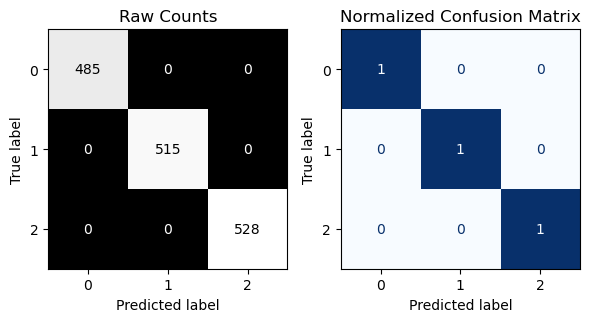


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       198
           1       0.77      0.72      0.74       155
           2       0.73      0.78      0.76       157

    accuracy                           0.78       510
   macro avg       0.77      0.77      0.77       510
weighted avg       0.78      0.78      0.78       510



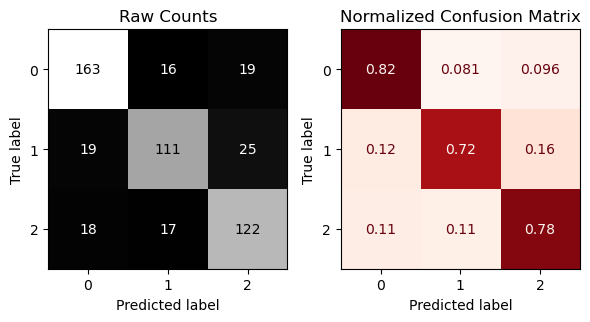

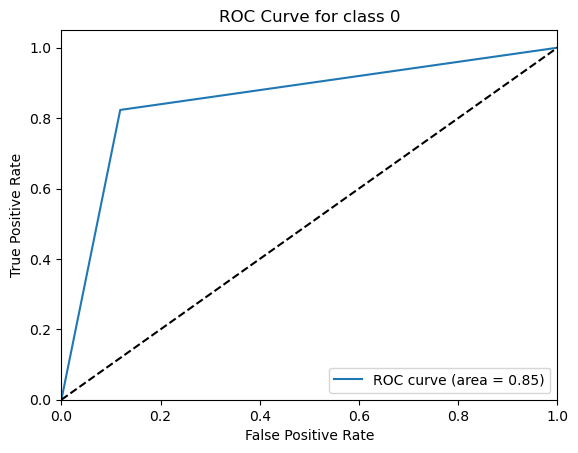

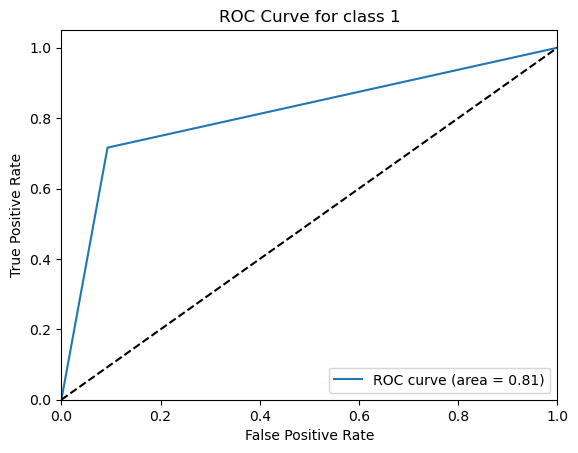

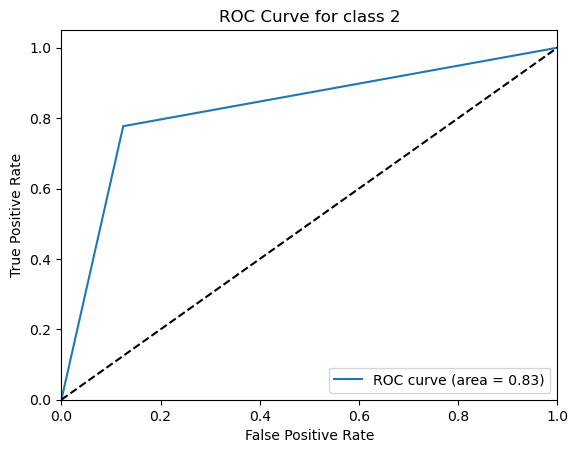

Average ROC AUC score: 0.8300396727941273


In [22]:
evaluate_classification(tree_pipe, X_train, y_train, X_test, y_test, num_classes=3,
                        figsize=(6,4), normalize='true', output_dict = False,
                        cmap_train='Blues', cmap_test="Reds",colorbar=False)

## Random Forest

In [23]:
## Instantiate and fit random forest model
rf = RandomForestClassifier()
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       528

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



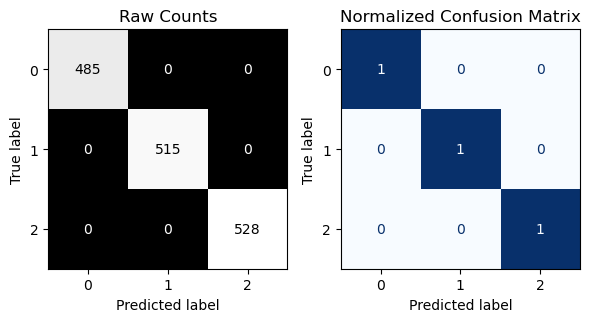


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       198
           1       0.75      0.70      0.72       155
           2       0.69      0.81      0.75       157

    accuracy                           0.76       510
   macro avg       0.76      0.76      0.75       510
weighted avg       0.76      0.76      0.76       510



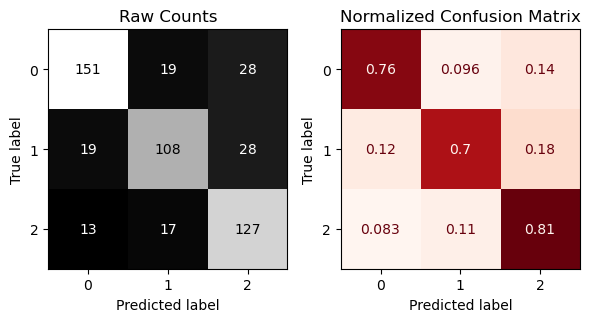

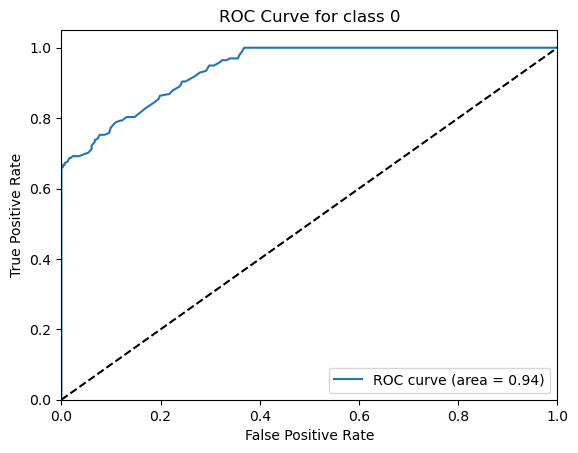

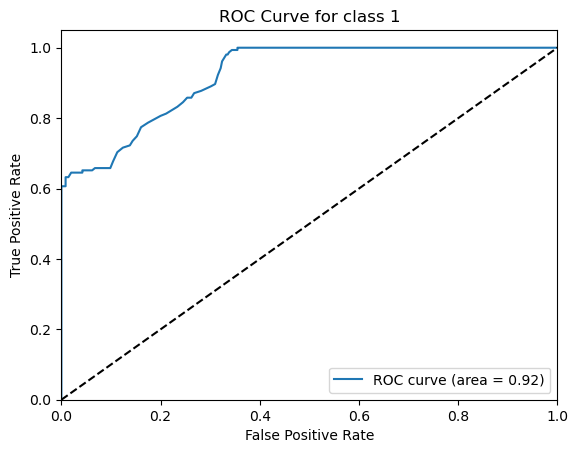

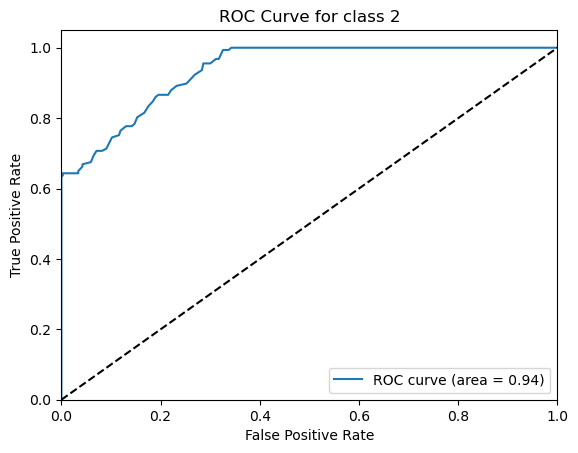

Average ROC AUC score: 0.9331862570689001


In [24]:
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

## LightGBM

In [25]:
## Instantiate and fit lightgbm model 
lgb = LGBMClassifier()
lgb_pipe = make_pipeline(prepocessor, lgb)

lgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier', LGBMClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      1.00      1.00       515
           2       1.00      1.00      1.00       528

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



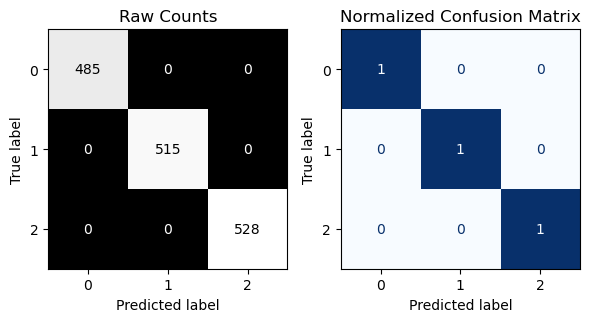


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       198
           1       0.75      0.74      0.74       155
           2       0.71      0.78      0.74       157

    accuracy                           0.77       510
   macro avg       0.77      0.77      0.77       510
weighted avg       0.77      0.77      0.77       510



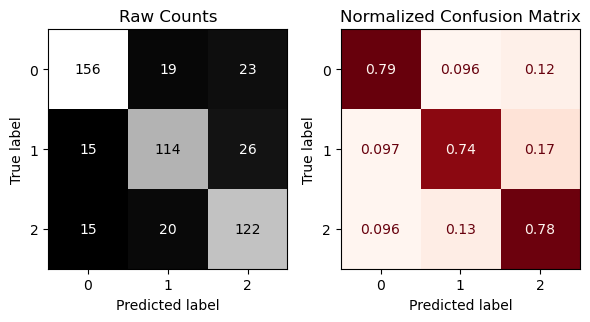

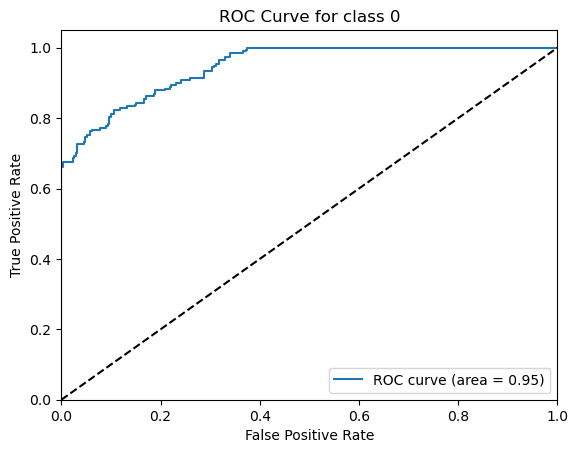

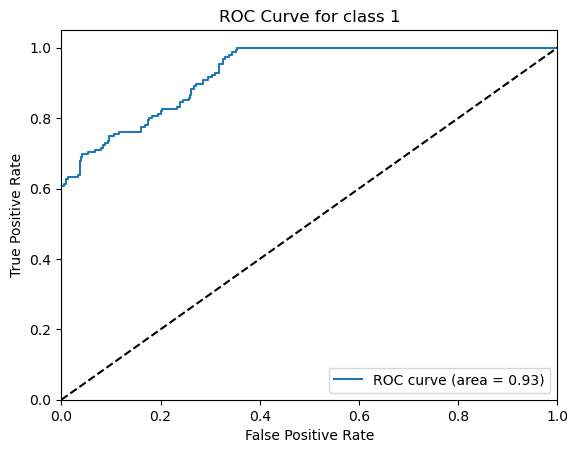

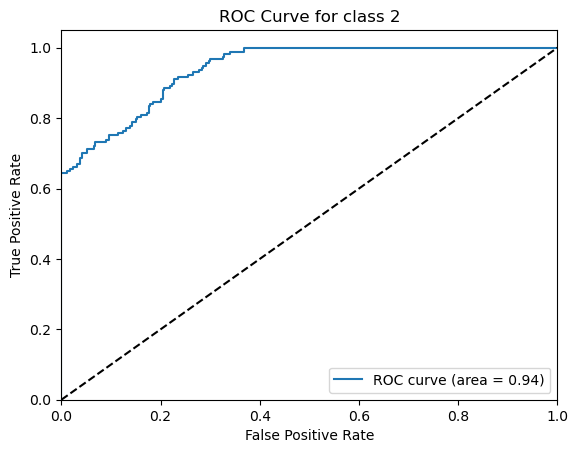

Average ROC AUC score: 0.9381907526812411


In [26]:
evaluate_classification(lgb_pipe, X_train, y_train, X_test, y_test)

# Hyperparameter Tuning with GridSearch CV

## Decision Tree

In [27]:
## Get model parameters
tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                     verbose_feature_names_out=False)),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                   verbose_feature_names_out=False),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_colu

In [28]:
## Parameters to be tested
param_grid = {'decisiontreeclassifier__class_weight': [None, 'balanced'],
              'decisiontreeclassifier__max_depth': [None, 10, 100, 1000],
              'decisiontreeclassifier__max_leaf_nodes': [None, 10, 100, 1000]} 

In [29]:
## Fit and evaluate
tree_gs = GridSearchCV(tree_pipe, param_grid, verbose=2)
tree_gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV]

[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassi

[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=100, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=100, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=100, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weig

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__class_weight': [None,
                                                                  'balanced'],
                         'decisiontreeclassifier__max_depth': [None, 10, 100,
                                                               1000],
                         'decisiontreeclassifier__max_leaf_nodes': [None, 10,
                                                                    100,
                                                                    1000]},
             verbose=2)

In [30]:
tree_gs.best_params_

{'decisiontreeclassifier__class_weight': 'balanced',
 'decisiontreeclassifier__max_depth': 10,
 'decisiontreeclassifier__max_leaf_nodes': 1000}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       485
           1       0.98      0.95      0.96       515
           2       0.96      0.95      0.96       528

    accuracy                           0.96      1528
   macro avg       0.96      0.96      0.96      1528
weighted avg       0.96      0.96      0.96      1528



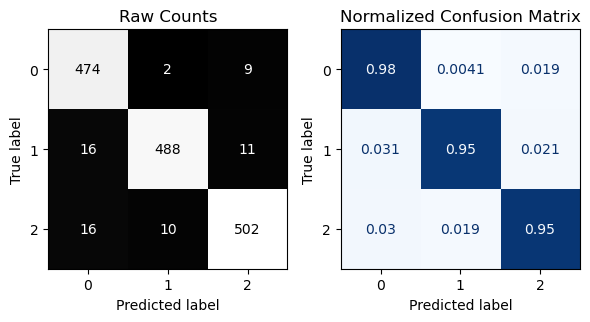


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       198
           1       0.75      0.71      0.73       155
           2       0.76      0.78      0.77       157

    accuracy                           0.77       510
   macro avg       0.77      0.77      0.77       510
weighted avg       0.77      0.77      0.77       510



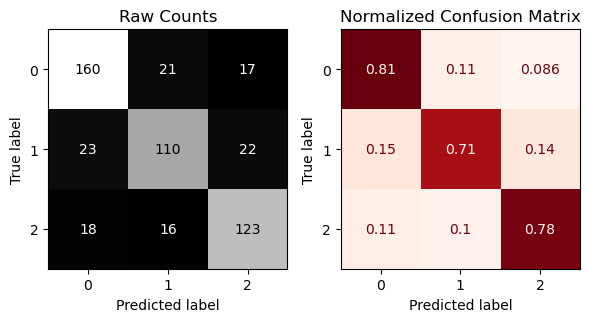

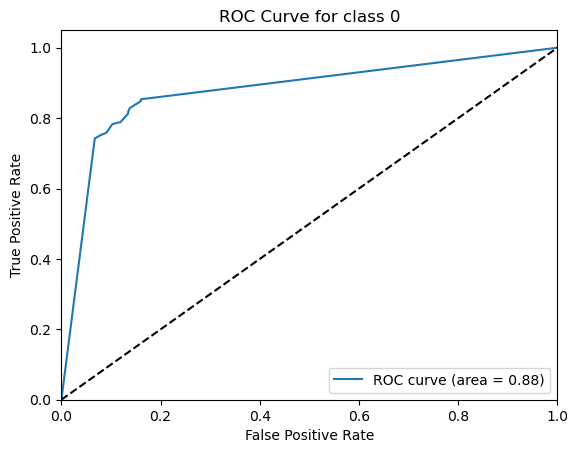

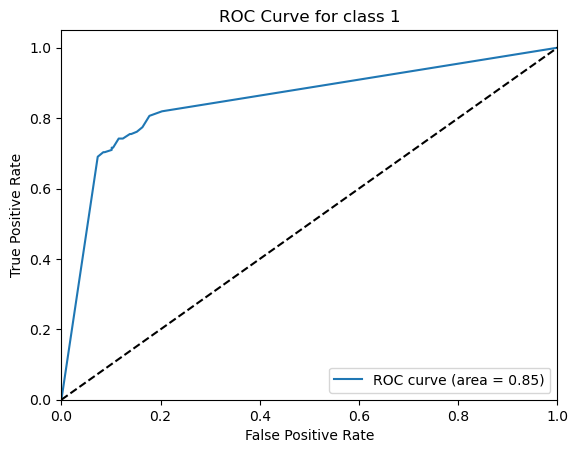

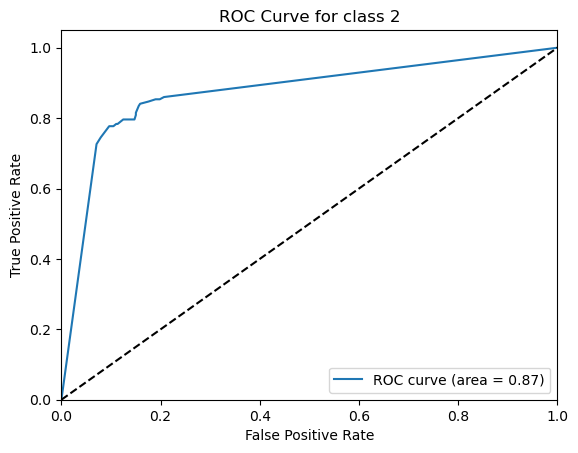

Average ROC AUC score: 0.8660543637007576


In [31]:
## Fit best estimator
best_tree_gs = tree_gs.best_estimator_
best_tree_gs.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(best_tree_gs, X_train, y_train, X_test, y_test)

## Random Forest

In [32]:
## Get model parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                   verbose_feature_names_out=False),
 'randomforestclassifier': RandomForestClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_colu

In [33]:
## Parameters to be tested
param_grid = {'randomforestclassifier__class_weight': ['balanced'],
              'randomforestclassifier__max_depth': [10, 100, 1000],
              'randomforestclassifier__max_leaf_nodes': [10, 100, 1000],
              'randomforestclassifier__n_estimators': [10, 100]} 

In [34]:
## Fit and evaluate
rf_gs = GridSearchCV(rf_pipe, param_grid, verbose=2)
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestcl

[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.0s


[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001390ADAE2E0>)],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__max_depth': [10, 100, 1000],
                         'randomforestclassifier__max_leaf_nodes': [10, 100,
                                                                    1000],
                         'randomforestclassifier__n_estimators': [10, 100]},
             verbose=2)

In [35]:
rf_gs.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 1000,
 'randomforestclassifier__max_leaf_nodes': 100,
 'randomforestclassifier__n_estimators': 100}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      0.99      1.00       515
           2       0.99      1.00      1.00       528

    accuracy                           1.00      1528
   macro avg       1.00      1.00      1.00      1528
weighted avg       1.00      1.00      1.00      1528



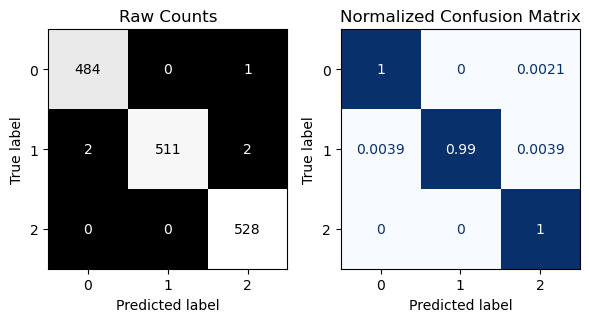


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       198
           1       0.79      0.69      0.74       155
           2       0.68      0.82      0.74       157

    accuracy                           0.77       510
   macro avg       0.77      0.76      0.76       510
weighted avg       0.77      0.77      0.77       510



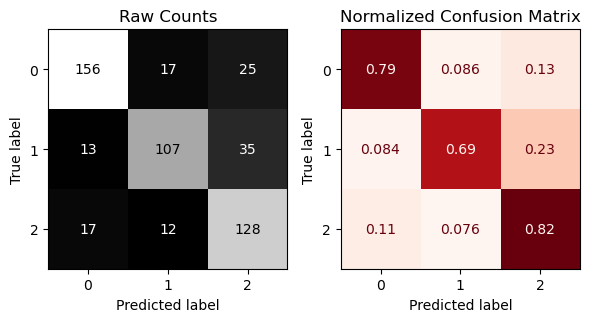

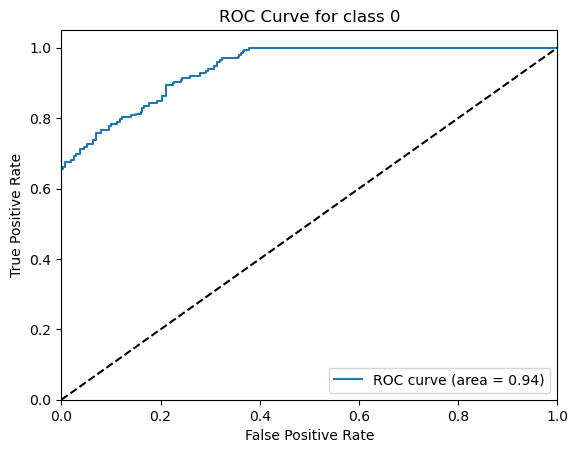

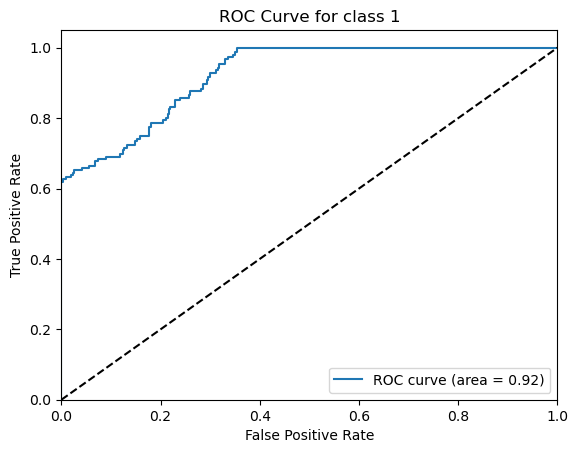

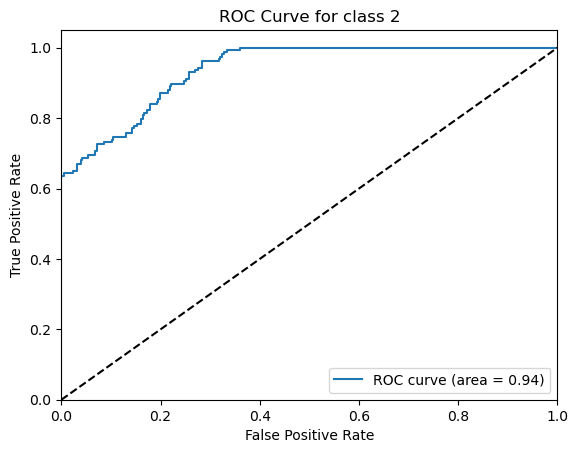

Average ROC AUC score: 0.9340593964870417


In [36]:
## Fit best estimator
best_rf_gs = rf_gs.best_estimator_
best_rf_gs.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(best_rf_gs, X_train, y_train, X_test, y_test)

In [37]:
best_rf_gs

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001390C481100>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=1000,
                                        max_leaf_nodes=100))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       485
           1       0.93      0.73      0.82       515
           2       0.74      0.85      0.79       528

    accuracy                           0.80      1528
   macro avg       0.81      0.80      0.80      1528
weighted avg       0.81      0.80      0.80      1528



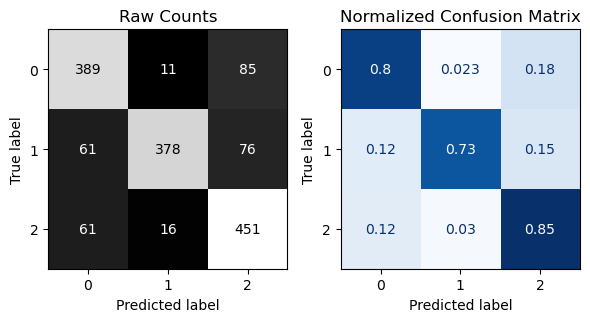


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       198
           1       0.86      0.66      0.75       155
           2       0.67      0.82      0.74       157

    accuracy                           0.76       510
   macro avg       0.77      0.76      0.76       510
weighted avg       0.78      0.76      0.76       510



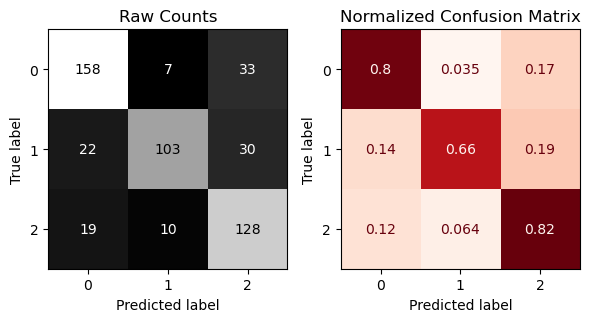

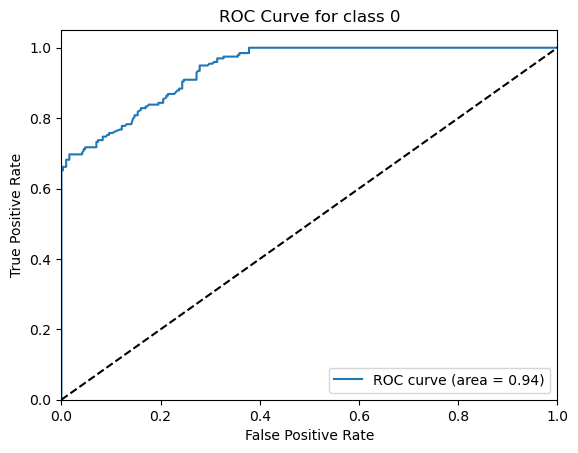

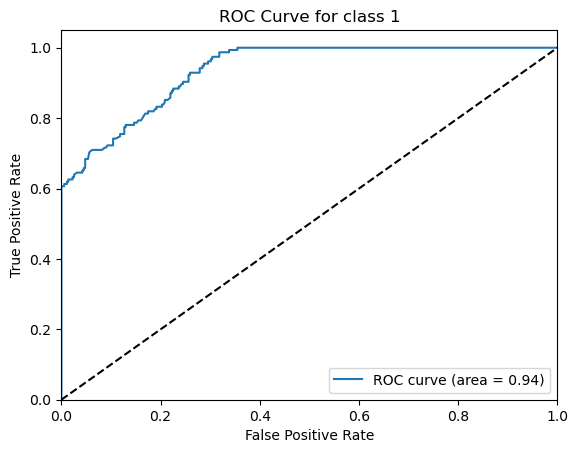

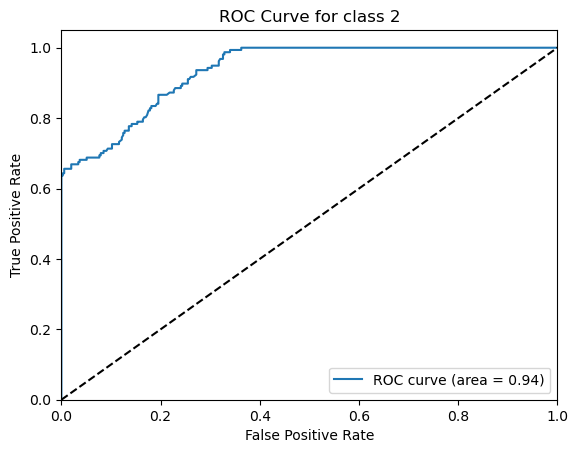

Average ROC AUC score: 0.9367286232910521


In [38]:
## Instantiate and fit random forest model
rf = RandomForestClassifier(class_weight='balanced', max_depth=1000, 
                            n_estimators=10, max_leaf_nodes=10)
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

# Final Model Explanation

In [39]:
# Access the RandomForestClassifier from the pipeline
rf_classifier = best_rf_gs.named_steps['randomforestclassifier']

# Extract feature importances
feature_names = rf_pipe[:-1].get_feature_names_out()  # Getting feature names correctly from the pipeline
feature_importance = pd.Series(rf_classifier.feature_importances_, index=feature_names)

# Create a DataFrame from the series for easier handling with Plotly
feature_importance_df = pd.DataFrame({'Feature': feature_importance.index, 'Importance': feature_importance.values})

# Sort the DataFrame by importance
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Visualize using Plotly Express - showing all features or just top 4 if needed
fig = px.bar(sorted_feature_importance_df, x='Importance', y='Feature', orientation='h', 
             title='Average Feature Importances')
fig.update_layout(xaxis_title='Feature Importance Value', yaxis_title='Feature Name')

# Show the plot
fig.show()

In [40]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier, X_train)
shap_values = explainer(X_test)

print(explainer)
type(shap_values)

shap._explanation.Explanation

In [41]:
print(np.shape(shap_values))

(510, 6, 3)


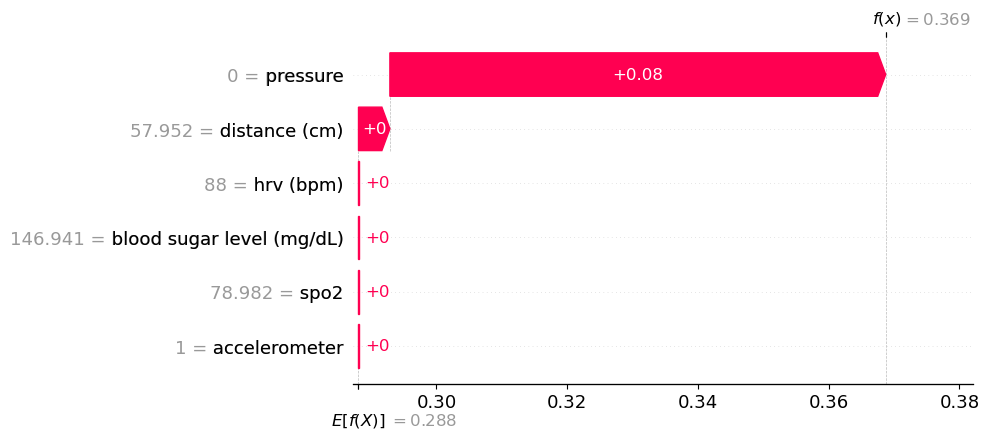

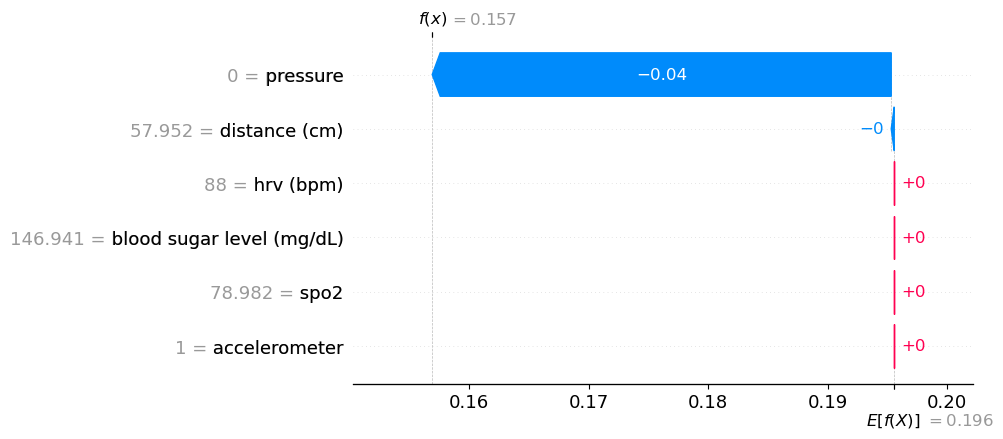

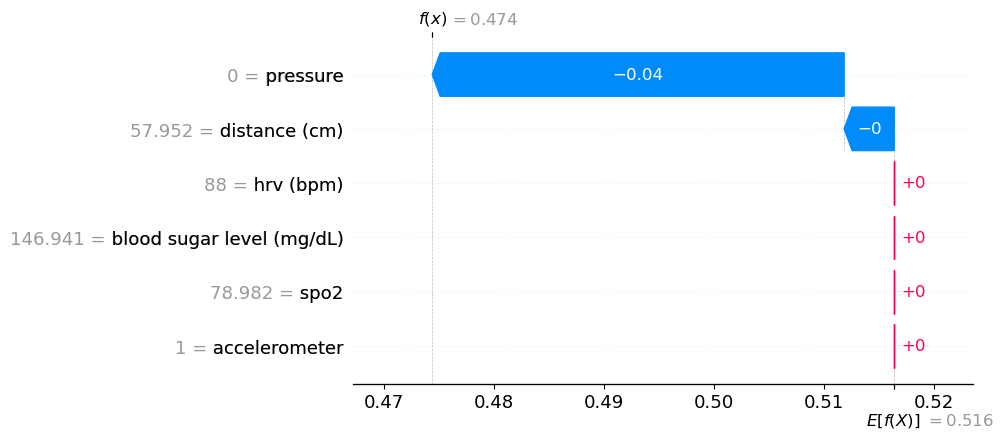

In [42]:
shap.plots.waterfall(shap_values[9, :, 0])
shap.plots.waterfall(shap_values[9, :, 1])
shap.plots.waterfall(shap_values[9, :, 2])